In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 10
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'':
  os.chdir(r'')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


C:\Users\kerry\AppData\Local\Temp\ipykernel_18096\1140549349.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\importlib\\_bootstrap.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\importlib\\_bootstrap_external.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\codecs.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\encodings\\aliases.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\encodings\\__init__.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\encodings\\utf_8.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\encodings\\cp1252.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\abc.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\io.py": 1665532704.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\li

In [2]:
from sqlalchemy import create_engine
import pymssql
import pandas as pd

server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" # paste password between quote marks
database = "ghz"

string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

data = pd.read_sql(
    """
    select ticker, date, ret, roeq, mom12m
    from data
    where date='2021-01'
    """, 
    conn
)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2542 entries, 0 to 2547
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  2542 non-null   object 
 1   date    2542 non-null   object 
 2   ret     2542 non-null   float64
 3   roeq    2542 non-null   float64
 4   mom12m  2542 non-null   float64
dtypes: float64(3), object(2)
memory usage: 119.2+ KB


In [3]:
from sklearn.tree import DecisionTreeClassifier

data['class'] = data.ret.transform(
  lambda x: pd.qcut(x, 3, labels=(0, 1, 2))
)
X = data[["roeq", "mom12m"]]
y = data["class"]

model = DecisionTreeClassifier(max_depth=2)
_ = model.fit(X, y)

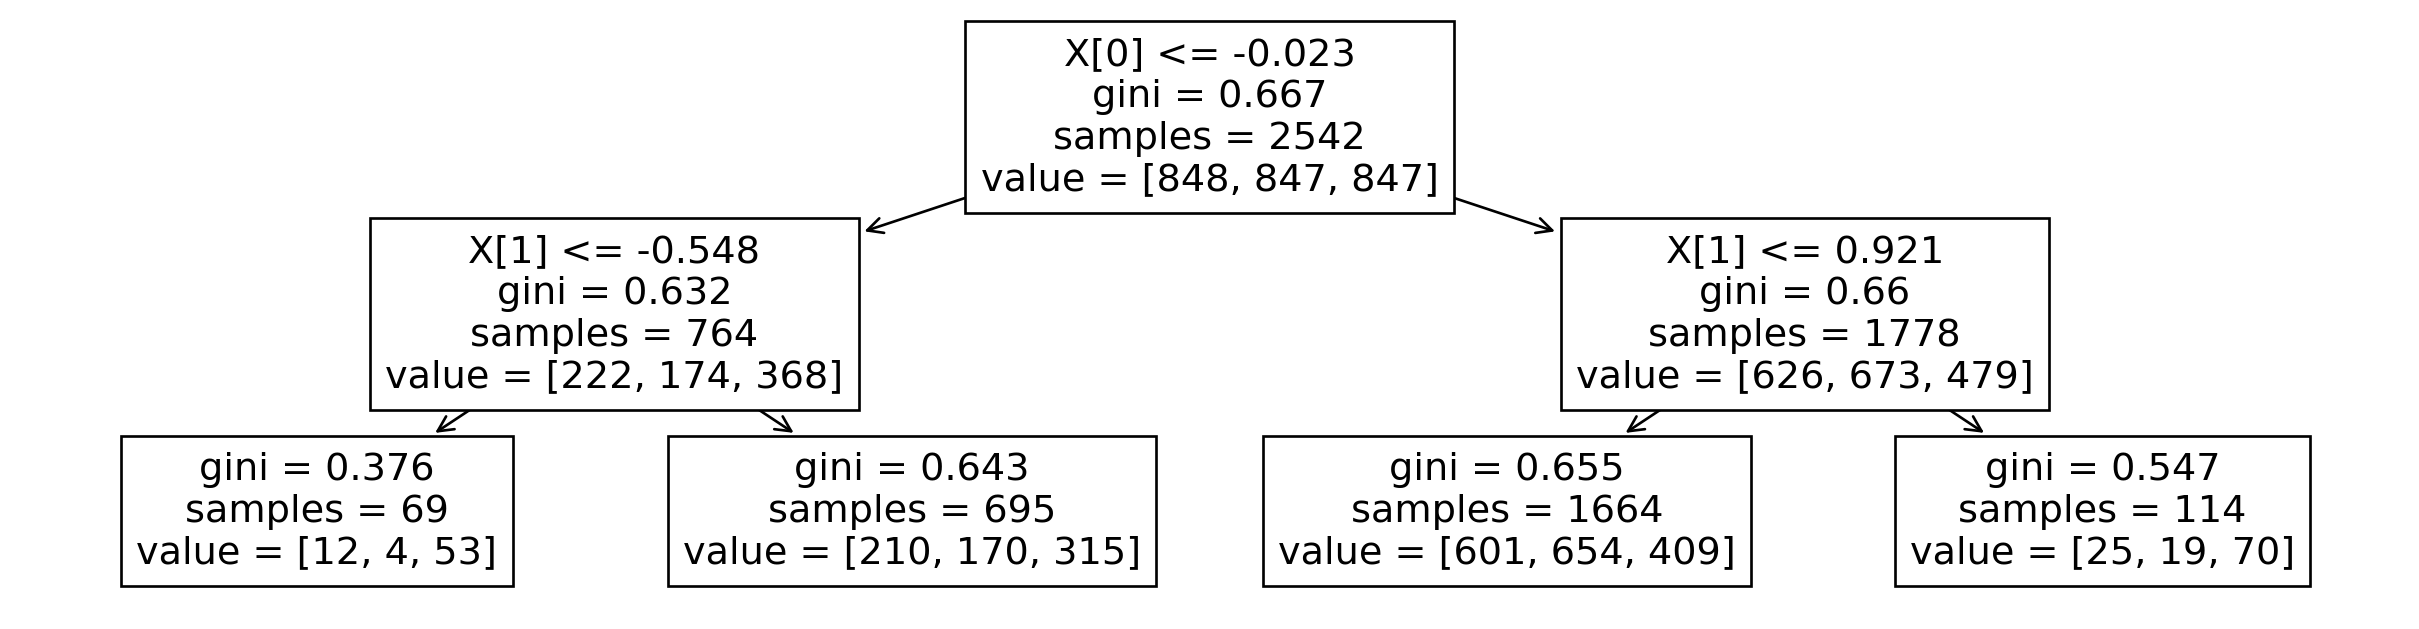

In [4]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (16,4)


plot_tree(model)
plt.show()

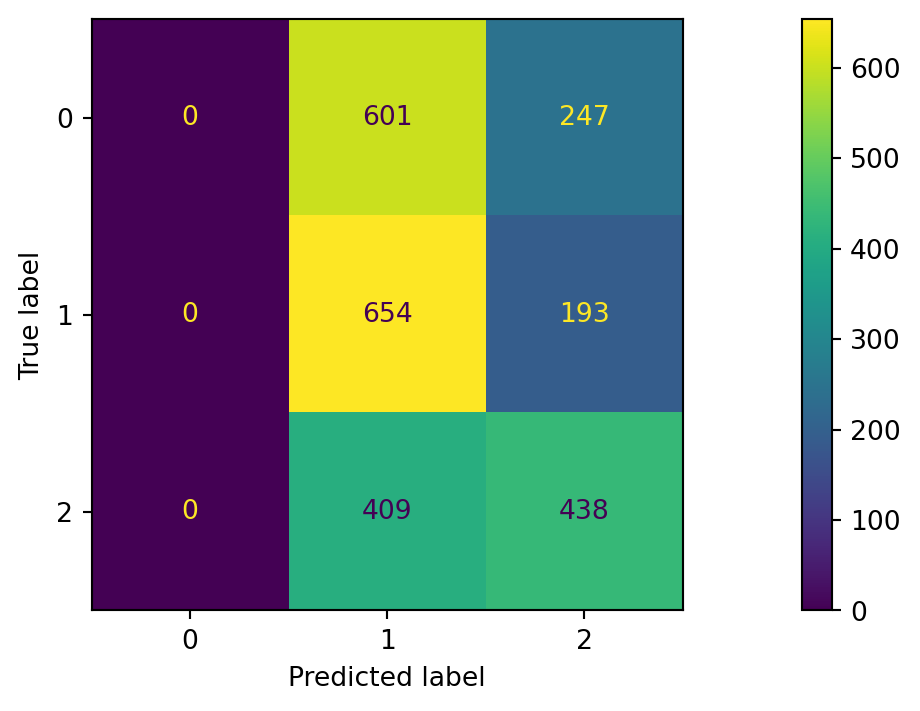

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X=X, y=y)
plt.show()

In [6]:
from sklearn.tree import DecisionTreeRegressor

X = data[["roeq", "mom12m"]]
y = data["ret"]

model = DecisionTreeRegressor(max_depth=2, random_state=0)
_ = model.fit(X, y)

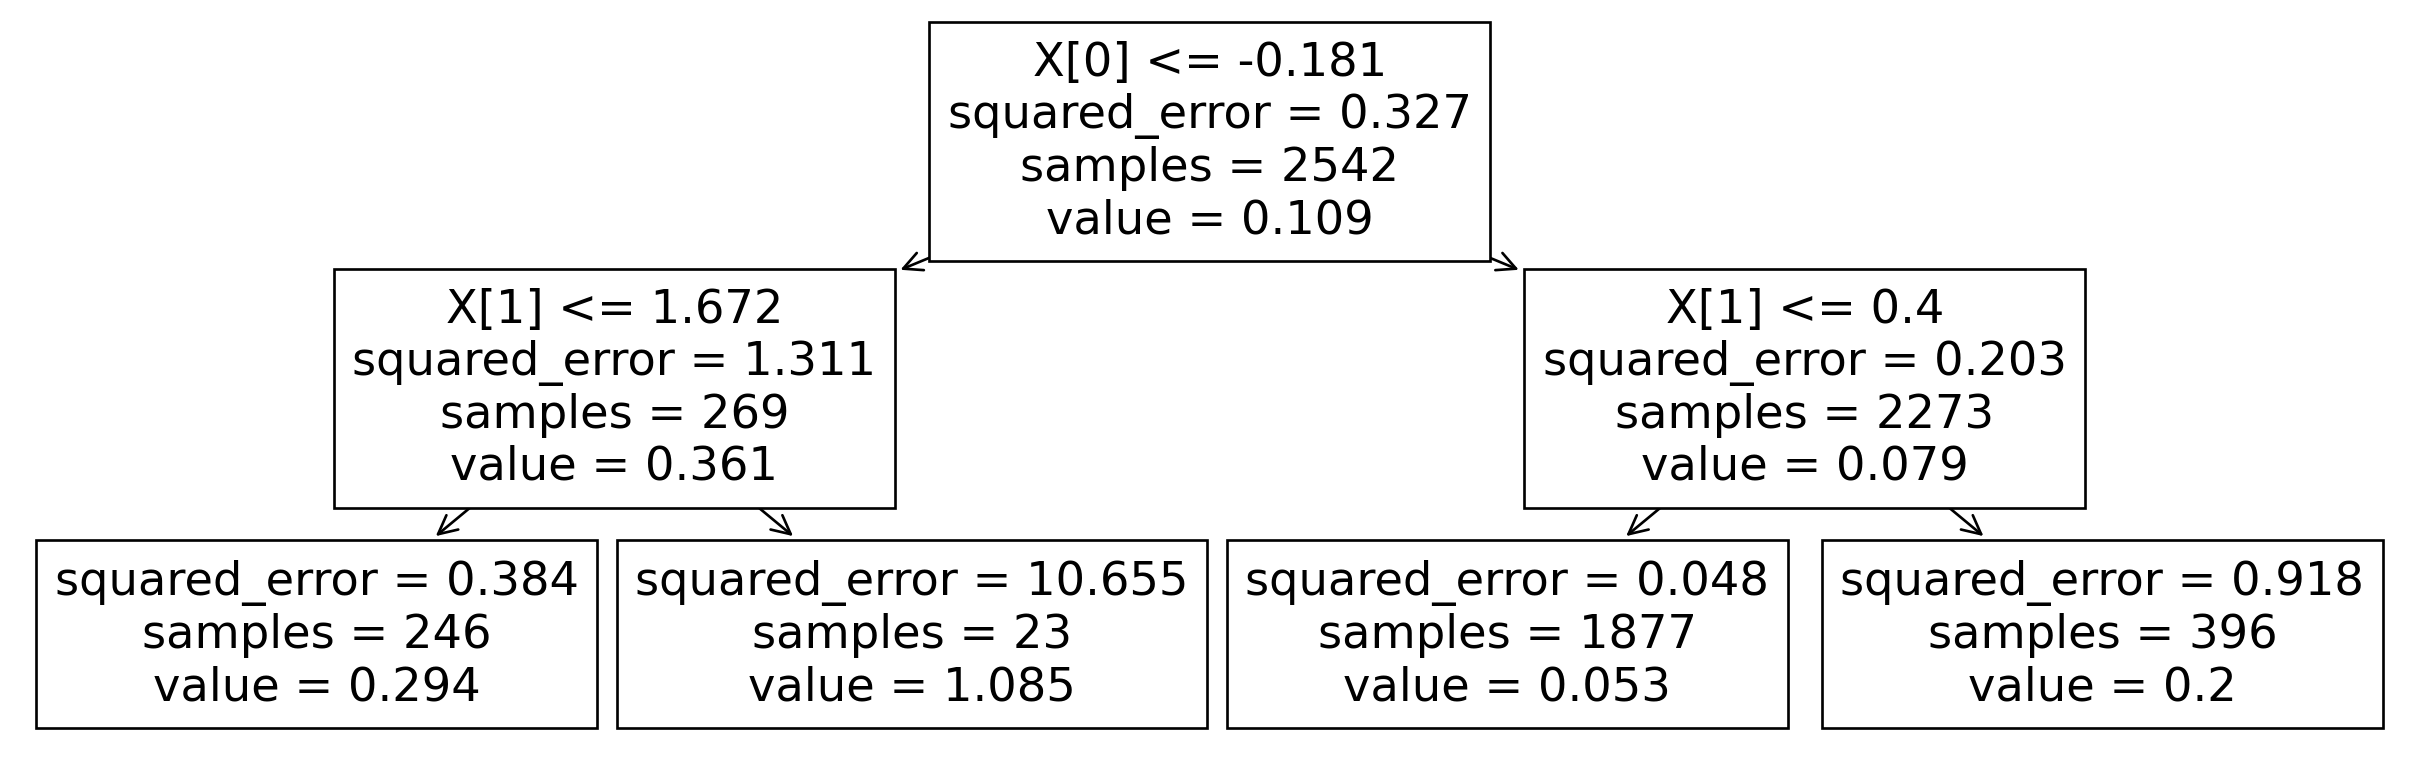

In [7]:
mpl.rcParams["figure.figsize"] = (16,5)

plot_tree(model)
plt.show()

In [8]:
subset = data[
  (data.roeq<=-0.181) & (data.mom12m>1.672)
]
subset

,ticker,date,ret,roeq,mom12m,class
28,KSPN,2021-01,1.635680,-1.526803,3.986288,2
136,PACB,2021-01,0.247109,-0.382200,2.075876,2
162,IBIO,2021-01,0.523810,-0.892083,3.986288,2
241,CLIR,2021-01,0.361775,-0.182654,2.357377,2
248,CRDF,2021-01,-0.344080,-0.671333,3.986288,0
249,IDEX,2021-01,0.944724,-0.793602,2.237116,2
397,IPWR,2021-01,1.095471,-0.270806,2.908696,2
425,TRVN,2021-01,0.018692,-0.216079,1.984897,1
458,LPCN,2021-01,0.301471,-0.972074,3.156924,2
528,MARA,2021-01,0.986590,-0.681703,3.986288,2


In [9]:
data['rnk'] = data.ret.rank(pct=True)

X = data[["roeq", "mom12m"]]
y = data["rnk"]

model = DecisionTreeRegressor(max_depth=2, random_state=0)
_ = model.fit(X, y)

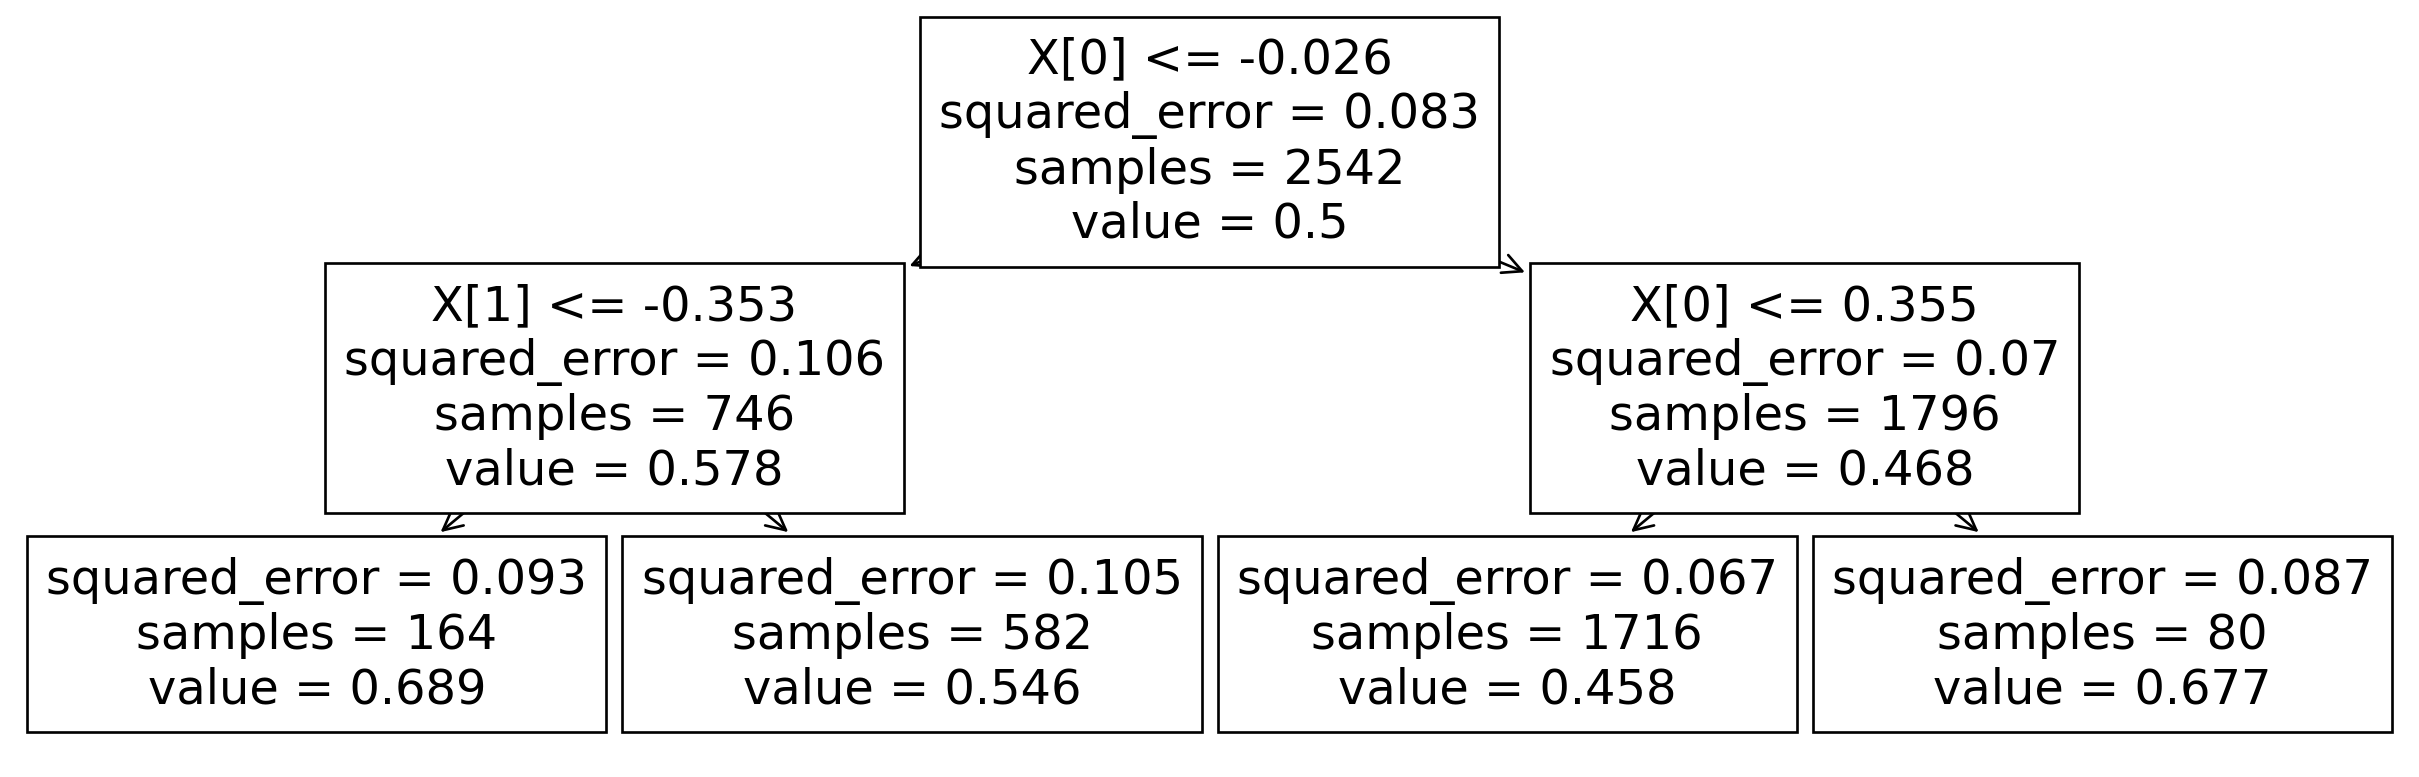

In [10]:
mpl.rcParams["figure.figsize"] = (16,5)

plot_tree(model)
plt.show()

In [11]:
X = data[["roeq", "mom12m"]]
y = data["class"]

model = DecisionTreeRegressor(max_depth=2, random_state=0)
_ = model.fit(X, y)

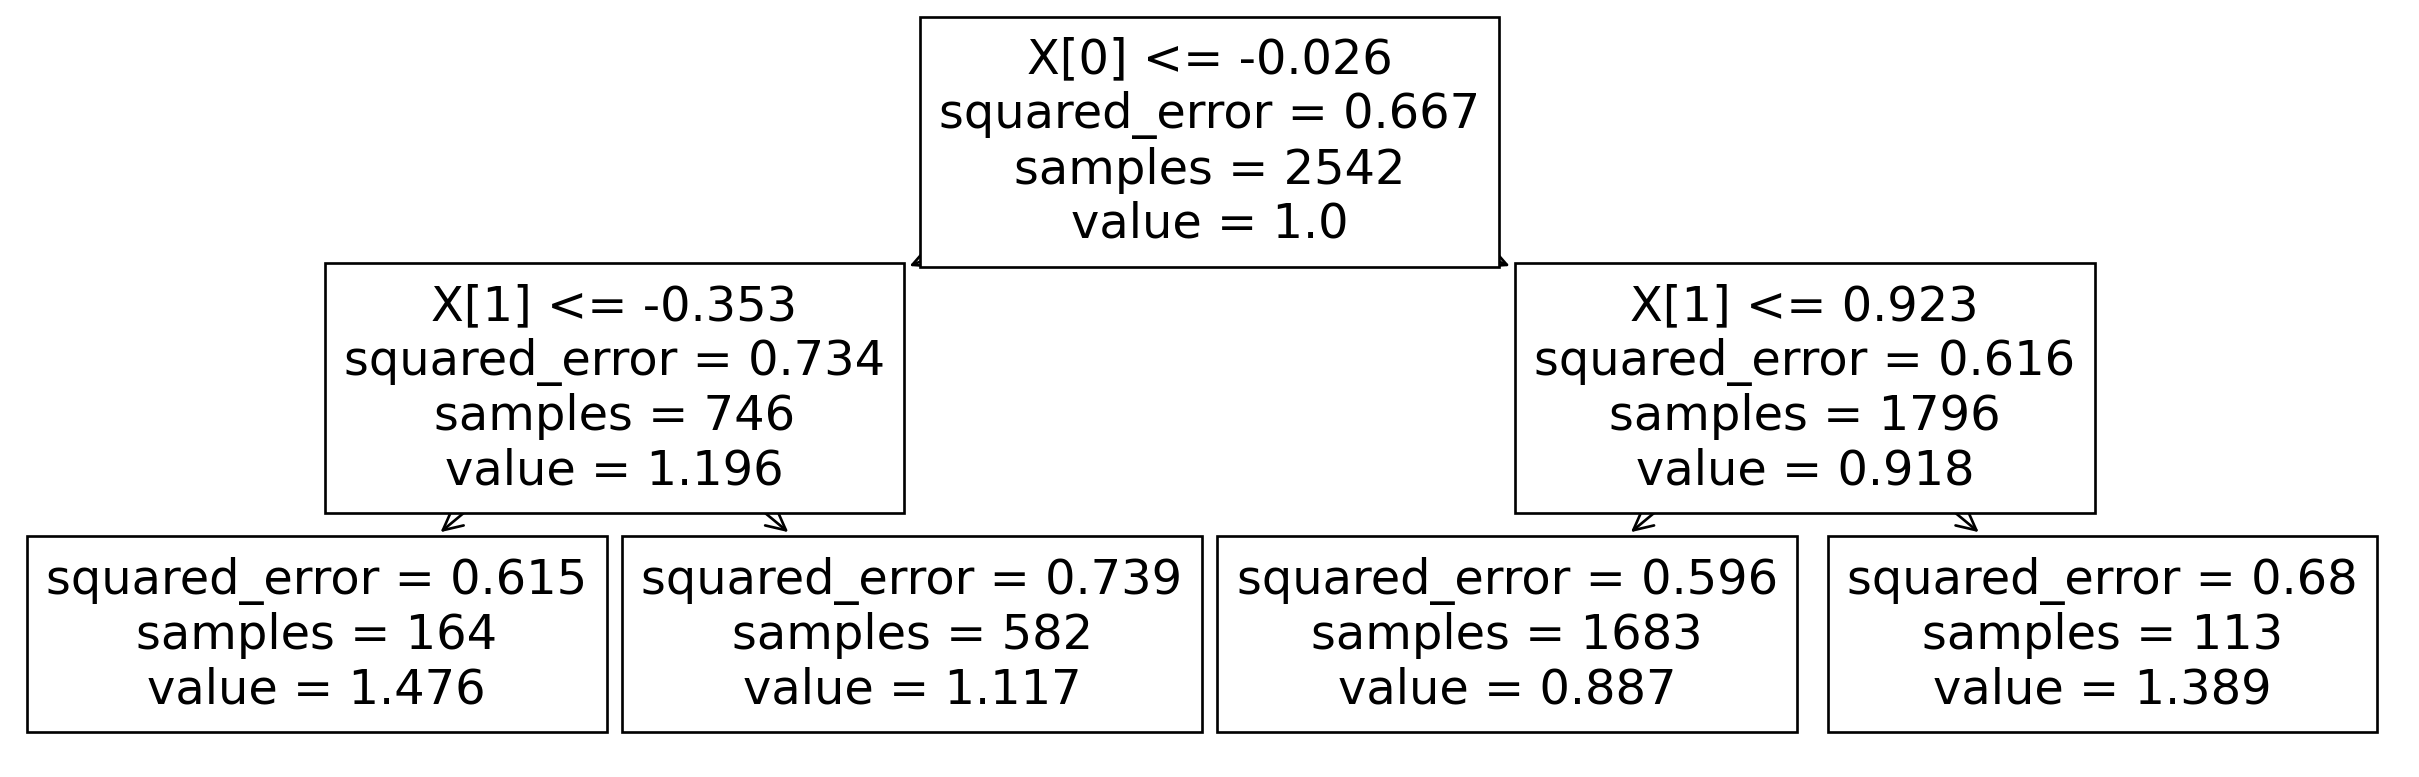

In [12]:
mpl.rcParams["figure.figsize"] = (16,5)

plot_tree(model)
plt.show()